In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [4]:
pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 23.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import gdown
import py7zr
from pathlib import Path
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import warnings

# ignores all future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

In [6]:
# Data import
person = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/person.csv")
appliances = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/appliance.csv")
other_appliances = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/other_appliance.csv")
home = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/home.csv")
survey = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/survey_data/survey_responses.csv")

#energy = pd.read_csv("https://media.githubusercontent.com/media/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/sensor_data/household_sensors_electric.csv")

In [7]:
def load_processed_data():
    """Load preprocessed sensor data with fallback to Drive download"""
    file_id = "1iJYaVc4HnubOOMhKJwc0Z3GpawacPipd"

    download_path = Path('raw/sensor')
    download_path.mkdir(parents=True, exist_ok=True)
    
    seven_zip_file = download_path / "sensor_data.7z"  # Adjust filename if needed
    file_path_energy = download_path / 'household_sensors_electric.csv'
    file_path_gas = download_path / 'household_sensors_gas.csv'

    # Download if the CSV files are missing
    if not file_path_energy.exists() or not file_path_gas.exists():
        print("Downloading from Google Drive...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(seven_zip_file), quiet=False)

        # Ensure the 7z file is actually downloaded
        if not seven_zip_file.exists():
            raise FileNotFoundError("Download failed. 7z file not found.")

        # Extract the 7z archive
        print("Extracting files...")
        with py7zr.SevenZipFile(seven_zip_file, mode='r') as archive:
            archive.extractall(path=download_path)

    # Ensure extracted files exist
    if file_path_energy.exists() and file_path_gas.exists():
        energy = pd.read_csv(file_path_energy)
        gas = pd.read_csv(file_path_gas)
        print(f"Data loaded successfully: {energy.shape} rows & {gas.shape} rows")
        return energy, gas
    else:
        raise FileNotFoundError("Could not find extracted CSV files.")

# Load and clean data
energy, gas = load_processed_data()


Downloading...
From: https://drive.google.com/uc?id=1iJYaVc4HnubOOMhKJwc0Z3GpawacPipd
To: /kaggle/working/raw/sensor/sensor_data.7z
100%|██████████| 42.9M/42.9M [00:00<00:00, 175MB/s] 


Extracting files...
Data loaded successfully: (1529499, 11) rows & (634755, 11) rows


In [8]:
# Group total energy consumption per home
total_consumption_per_home_energy = energy.groupby('consumer_id', as_index=False)['total_consumption_Wh'].sum()
total_consumption_per_home_energy['home'] = total_consumption_per_home_energy['consumer_id'].str.extract('(\d+)').astype(int)
total_consumption_per_home_energy = total_consumption_per_home_energy.drop(columns=['consumer_id'])
total_consumption_per_home_energy = total_consumption_per_home_energy.rename(columns={"total_consumption_Wh": "energy_total_consumption_Wh"})

# Group total gas consumption per home
total_consumption_per_home_gas = gas.groupby('consumer_id', as_index=False)['total_consumption_Wh'].sum()
total_consumption_per_home_gas['home'] = total_consumption_per_home_gas['consumer_id'].str.extract('(\d+)').astype(int)
total_consumption_per_home_gas = total_consumption_per_home_gas.drop(columns=['consumer_id'])
total_consumption_per_home_gas = total_consumption_per_home_gas.rename(columns={"total_consumption_Wh": "gas_total_consumption_kWh"})

In [9]:
# Group and calculate appliances per household
appliances = appliances[appliances['powertype'] == 'electric']
appliances = appliances.drop(columns=['appliancetype', 'applianceclass', 'appliancesubtype', 'roomid'])
appliances["amount"] = 1 * appliances["number"]
appliances.drop(columns=['number'], inplace=True)
appliances_group = appliances.groupby('homeid', as_index=False)["amount"].sum()

# Group and calculate other_appliances per household
other_appliances['num_clean'] = other_appliances['number'].str.replace(r'\D', '', regex=True)
other_appliances['num_clean'] = other_appliances['num_clean'].astype(int)
other_appliances = other_appliances[~other_appliances['appliance_name'].str.contains('gas', case=False, na=False)]
other_appliances["amount"] = 1 * other_appliances["num_clean"]
other_appliances.drop(columns=['number', 'num_clean'], inplace=True)
other_appliances_group = other_appliances.groupby('homeid', as_index=False)["amount"].sum()

# Merge the two dataframes
appliances_merged = pd.merge(appliances_group, other_appliances_group, on='homeid', how='inner')
appliances_merged['total_appliances'] = appliances_merged['amount_x'] + appliances_merged['amount_y']
appliances_merged = appliances_merged.drop(columns=['amount_x', 'amount_y'])
appliances_merged = appliances_merged.rename(columns={'homeid': 'home'})

In [10]:
# Group homes with income bands
result_grouped = home[["homeid", "income_band"]].groupby('homeid', as_index=False).sum()
result_grouped = result_grouped.rename(columns={'homeid': 'home'})

# Merge income bands with energy consumption
income_energy_home = pd.merge(result_grouped, total_consumption_per_home_energy, on='home', how='inner')
income_energy_home = pd.merge(income_energy_home, total_consumption_per_home_gas, on='home', how='inner')

# Change income bands to midpoint integers
income_midpoints = {
    "Missing": 0,
    "less than £10,800": 1,
    "£10,800 to £13,499": 2,
    "£13,500 to £16,199": 3,
    "£16,200 to £19,799": 4,
    "£19,800 to £23,399": 5,
    "£23,400 to £26,999": 6,
    "£27,000 to £32,399": 7,
    "£32,400 to £37,799": 8,
    "£37,800 to £43,199": 9,
    "£43,200 to £48,599": 10,
    "£48,600 to £53,999": 11,
    "£54,000 to £65,999": 12,
    "£66,000 to £77,999": 13,
    "£78,000 to £89,999": 14,
    "£90,000 or more": 15 }
income_energy_home["income_band_mid"] = income_energy_home["income_band"].map(income_midpoints)
income_energy_home = income_energy_home.drop(columns=['income_band'])

# Merge appliances with income bands and energy consumption
appliance_income_energy_home = pd.merge(appliances_merged, income_energy_home, on='home', how='inner')
appliance_income_energy_home

,home,total_appliances,energy_total_consumption_Wh,gas_total_consumption_kWh,income_band_mid
0,47,27,1187.852340,4252.895,0
1,59,24,3103.291434,10393.163,15
2,61,22,2136.057633,12100.781,11
3,62,22,3562.373903,17897.239,10
4,63,25,4879.234576,12600.345,12
...,...,...,...,...,...
249,331,29,301.531115,363.533,12
250,332,24,160.567792,324.532,8
251,333,14,252.520378,602.296,12
252,334,37,637.891330,502.753,1


## Handle education levels in person Data Frame
| Qualification                                                           | Value |
|-------------------------------------------------------------------------|-------|
| phd                                                                     | 9     |
| degree level qualification (or equivalent), e.g. bsc, ba, msc, ma       | 8     |
| higher educational qualification below degree level                    | 7     |
| onc / national level btec                                               | 6     |
| a-levels or highers                                                     | 5     |
| gcse grade d-g or cse grade 2-5 or standard grade level 4-6              | 4     |
| o level or gcse equivalent (grade a-c) or o grade/cse equivalent (grade 1) or standard grade level 1 | 3     |
| other qualifications                                                     | 2     |
| no formal qualifications                                                 | 1     |
| unknown                                                                 | 0     |



In [11]:
# Transform education column
person['education'] = person['education'].str.strip().str.lower()
person['education'] = person['education'].fillna('unknown')

# Map qualifications to numerical values
qualification_mapping = {
    "phd": 9,  # Highest qualification
    "degree level qualification (or equivalent), e.g. bsc, ba, msc, ma": 8,
    "higher educational qualification below degree level": 7,
    "onc / national level btec": 6,
    "a-levels or highers": 5,
    "gcse grade d-g or cse grade 2-5 or standard grade level 4-6": 4,
    "o level or gcse equivalent (grade a-c) or o grade/cse equivalent (grade 1) or standard grade level 1": 3,
    "other qualifications": 2, 
    "no formal qualifications": 1,
    "unknown": 0 } # Lowest qualification
person['education_map'] = person['education'].map(qualification_mapping)
person = person.rename(columns={'homeid': 'home'})

In [12]:
# Choose highest education per homeid for representation of household
highest_education = person.groupby('home')['education_map'].max().reset_index()

# Merge with appliance_income_energy_home
appliance_income_energy_education_home = pd.merge(appliance_income_energy_home, highest_education, on='home', how='inner')

In [36]:
appliance_income_energy_education_home

,home,total_appliances,energy_total_consumption_Wh,gas_total_consumption_kWh,income_band_mid,education_map
0,47,27,1187.852340,4252.895,0,8
1,59,24,3103.291434,10393.163,15,8
2,61,22,2136.057633,12100.781,11,5
3,62,22,3562.373903,17897.239,10,8
4,63,25,4879.234576,12600.345,12,8
...,...,...,...,...,...,...
249,331,29,301.531115,363.533,12,9
250,332,24,160.567792,324.532,8,8
251,333,14,252.520378,602.296,12,8
252,334,37,637.891330,502.753,1,9


## KMeans Clustering with Scaling

In [16]:
scaler = StandardScaler()

# Separate home identifier and clustering variables
df = appliance_income_energy_education_home.copy()
home = df['home']
dataset_clustering = df.drop(columns=['home'])
dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset_clustering),
                              columns=dataset_clustering.columns)

# Dictionary to hold silhouette scores for each number of clusters
silhouette_scores = {}
davies_bouldin_scores = {}

# Perform KMeans clustering iteratively for clusters 2 through 19
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, n_init='auto', max_iter=300, random_state=42)
    kmeans_model = kmeans.fit(dataset_scaled)
    km_clusters = kmeans.labels_
    
    sil_score = silhouette_score(dataset_scaled, km_clusters)
    silhouette_scores[i] = sil_score

    db_score = davies_bouldin_score(dataset_scaled, km_clusters)
    davies_bouldin_scores[i] = db_score
    print(f"{i} clusters | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f}")

# Find the cluster count with the highest silhouette score
best_clusters = max(silhouette_scores, key=silhouette_scores.get)
highest_score = silhouette_scores[best_clusters]
print(f"\nHighest silhouette score is {highest_score:.4f} with {best_clusters} clusters.")
print(f"Lowest Davies-Bouldin distance is {davies_bouldin_scores[min(davies_bouldin_scores, key=davies_bouldin_scores.get)]} with {min(davies_bouldin_scores, key=davies_bouldin_scores.get)} clusters. ")


2 clusters | Silhouette: 0.2854 | Davies-Bouldin: 1.5355
3 clusters | Silhouette: 0.2045 | Davies-Bouldin: 1.4917
4 clusters | Silhouette: 0.2225 | Davies-Bouldin: 1.2869
5 clusters | Silhouette: 0.2137 | Davies-Bouldin: 1.2744
6 clusters | Silhouette: 0.2152 | Davies-Bouldin: 1.3339
7 clusters | Silhouette: 0.2181 | Davies-Bouldin: 1.3463
8 clusters | Silhouette: 0.2091 | Davies-Bouldin: 1.3053
9 clusters | Silhouette: 0.1882 | Davies-Bouldin: 1.3365
10 clusters | Silhouette: 0.1877 | Davies-Bouldin: 1.2871
11 clusters | Silhouette: 0.2171 | Davies-Bouldin: 1.2183
12 clusters | Silhouette: 0.1879 | Davies-Bouldin: 1.2862
13 clusters | Silhouette: 0.1985 | Davies-Bouldin: 1.2359
14 clusters | Silhouette: 0.1929 | Davies-Bouldin: 1.2808
15 clusters | Silhouette: 0.1969 | Davies-Bouldin: 1.2178
16 clusters | Silhouette: 0.1940 | Davies-Bouldin: 1.2361
17 clusters | Silhouette: 0.1830 | Davies-Bouldin: 1.2391
18 clusters | Silhouette: 0.1950 | Davies-Bouldin: 1.1779
19 clusters | Silhouet

In [17]:
# Use 2 clusters for visualizations, as this is optimal value for silhouette score

# recalculate the model for two clusters
kmeans = KMeans(n_clusters=best_clusters, n_init='auto', max_iter=300, random_state=42)
kmeans_cluster_model = kmeans.fit(dataset_scaled)
km_clusters = kmeans.labels_
centroids = kmeans.cluster_centers_.T

# Plot the centroids for the clusters
centroids_df = pd.DataFrame(centroids.T, columns=dataset_scaled.columns)
clusters = [1, 2]

fig = go.Figure()
for column in centroids_df.columns:
    fig.add_trace(go.Bar(x=clusters, y=centroids_df[column], name=column))

fig.update_layout(yaxis_title='Count', barmode='group', title='K-means Clustering Results')
fig.show()

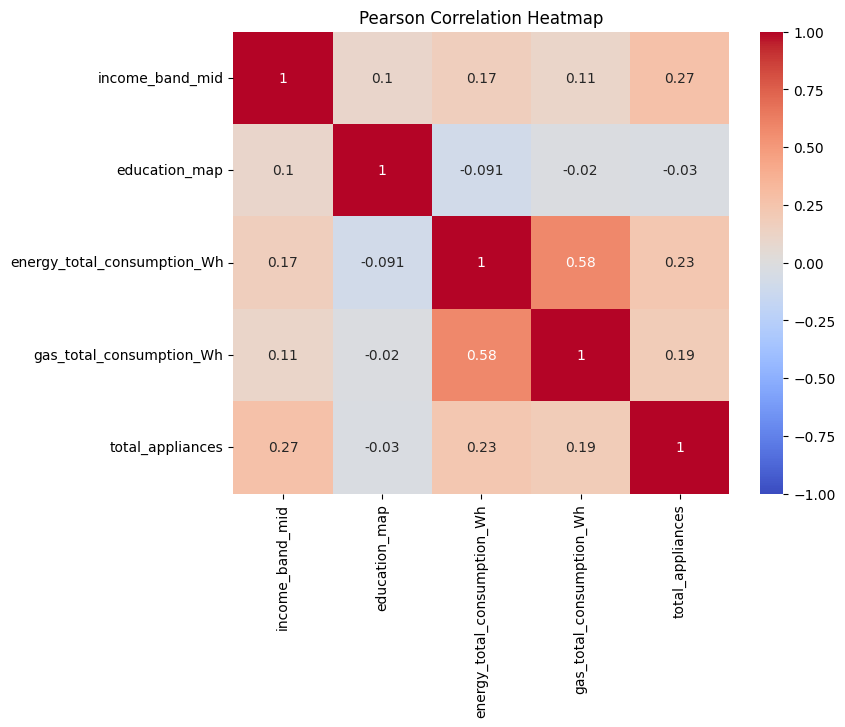

In [24]:
cols_of_interest = [
    "income_band_mid", 
    "education_map", 
    "energy_total_consumption_Wh", 
    "gas_total_consumption_kWh", 
    "total_appliances"
]

subset_df = dataset_scaled[cols_of_interest].copy()

# 3. Compute the correlation matrix
corr_matrix = subset_df.corr(method='pearson')

# 4. Plot a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap")
plt.show()

         total_appliances  energy_total_consumption_Wh  \
cluster                                                  
0               32.179487                  3926.327059   
1               25.897727                  1486.419298   

         gas_total_consumption_kWh  income_band_mid  education_map  
cluster                                                            
0                    19062.976372        10.589744       7.525641  
1                     6224.926409         8.113636       7.761364  


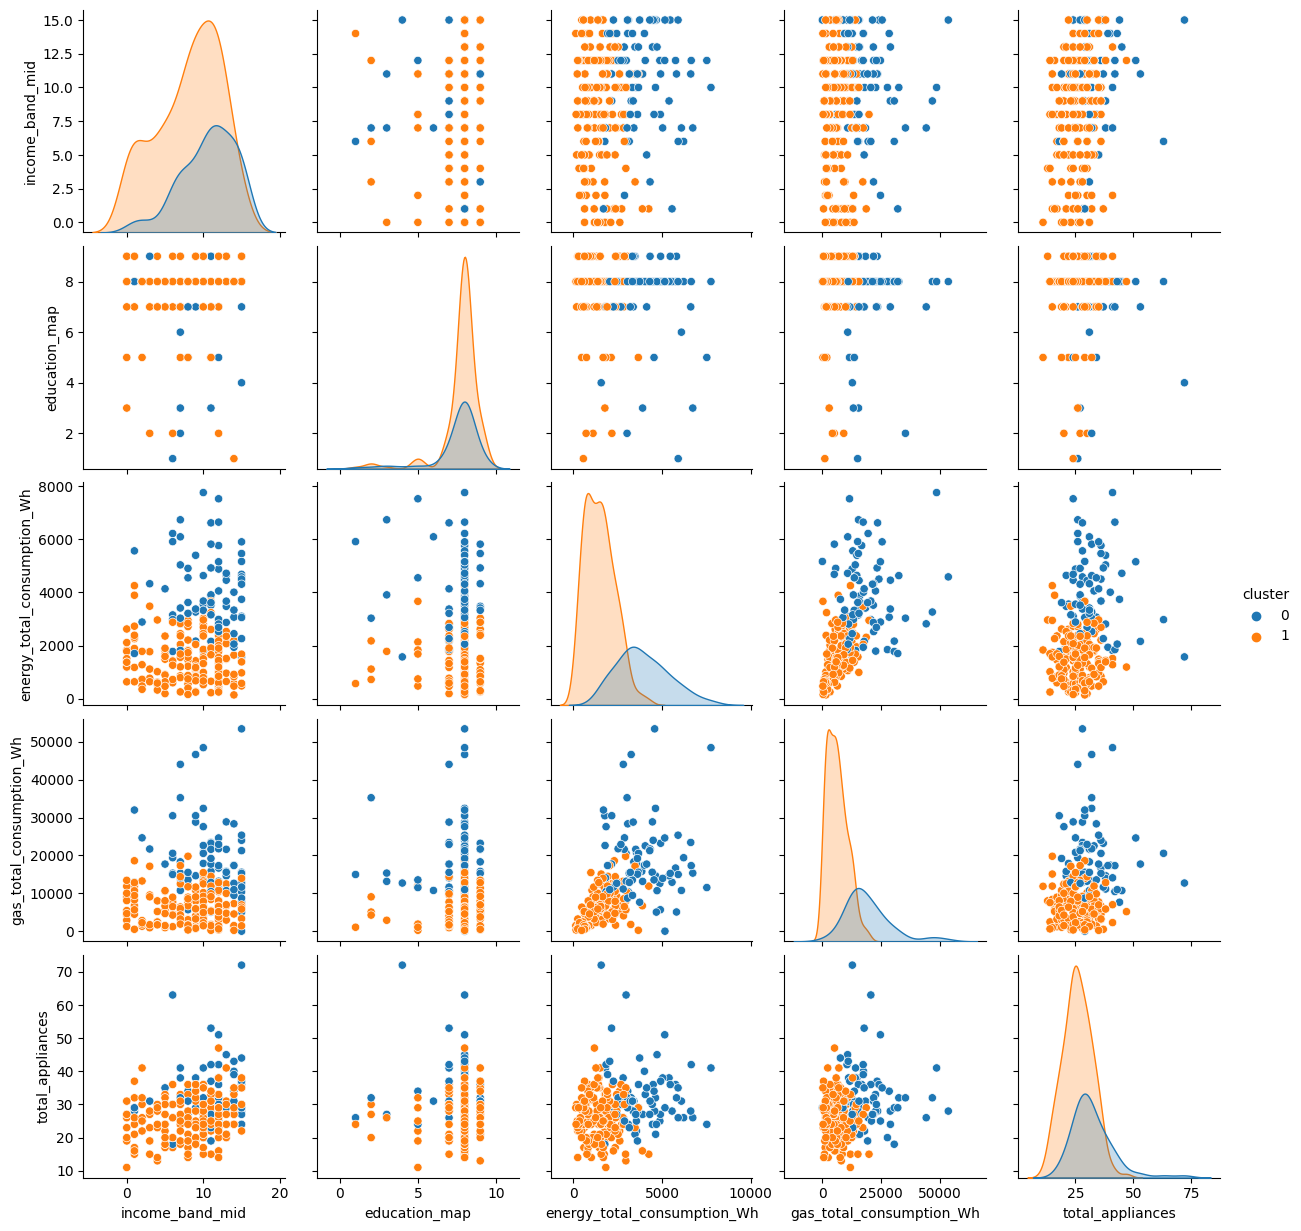

In [20]:
# Assign labels to the unscaled data
dataset_clustering["cluster"] = kmeans.labels_

# Analysis of mean values in cluster for better comparison
clustering_mean = dataset_clustering.groupby("cluster").mean()
print(clustering_mean.head())

#cluster_desc = dataset_clustering.groupby("cluster").describe()
#print(cluster_desc)

# Look at some homes in cluster 0
#cluster_0 = dataset_clustering[dataset_clustering["cluster"] == 0]
#print(cluster_0.head())

# Pair plot
sns.pairplot(dataset_clustering, hue="cluster", 
             vars=["income_band_mid", "education_map", "energy_total_consumption_Wh",
                   "gas_total_consumption_kWh", "total_appliances"])
plt.show()
